In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 크롤링 start_date, end_date
'''
start_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
end_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
'''
start_date = '2000-01-01'
end_date = '2020-12-31'
train_date = '2018-12-31'

In [4]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [5]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

# 2) 볼린저밴드 (주가의 이동평균선을 중심으로 표준편차 범위를 표시)
ubb, mbb, lbb = ta.BBANDS(model_samsung.Close, 20, 2)
model_samsung['ubb'] = ubb
model_samsung['mbb'] = mbb
model_samsung['lbb'] = lbb

# 1) 이평선(SMA, EMA, WMA) (w = 5,10,15,20,30,60,120)
model_samsung['ma_5'] = ta.SMA(model_samsung.Close, timeperiod=5)
model_samsung['ma_10'] = ta.SMA(model_samsung.Close, timeperiod=10)
model_samsung['ma_15'] = ta.SMA(model_samsung.Close, timeperiod=15)
model_samsung['ma_20'] = ta.SMA(model_samsung.Close, timeperiod=20)
model_samsung['ma_30'] = ta.SMA(model_samsung.Close, timeperiod=30)
model_samsung['ma_60'] = ta.SMA(model_samsung.Close, timeperiod=60)
model_samsung['ma_120'] = ta.SMA(model_samsung.Close, timeperiod=120)

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']

# SOX 지수
SOX = yf.download("^SOX", start=start_date, end=end_date)
SOX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOX = SOX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
model_samsung['exchange_rate_usd'] = exchange_rate_usd_
model_samsung['nasdaq'] = nasdaq_
model_samsung['russell_2000'] = russell_2000_
model_samsung['MSCI_KR'] = MSCI_KR
model_samsung['SOX'] = SOX
model_samsung['treasury_5y'] = treasury_5y_

In [7]:
# samsung 모델
model_samsung['Labeling'] = model_samsung['Close'].shift(-1)
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,ubb,mbb,...,ma_30,ma_60,ma_120,exchange_rate_usd,nasdaq,russell_2000,MSCI_KR,SOX,treasury_5y,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2012-04-30,27900,28180,27540,27800,315924,514.972445,386.143049,128.829397,27568.172985,26146.0,...,25918.000000,24566.000000,22634.000000,1130.15,3046.360107,816.880005,10609.0,413.390015,0.811,28200.0
2012-05-02,28200,28360,27980,28200,368585,619.193325,432.753104,186.440222,27933.771899,26257.0,...,26018.000000,24680.666667,22707.333333,1130.20,3059.850098,818.599976,10718.0,416.809998,0.819,28020.0
2012-05-03,28040,28200,27960,28020,206721,679.432553,482.088994,197.343559,28160.532041,26323.0,...,26107.333333,24789.666667,22776.666667,1131.25,3024.300049,806.590027,10655.0,406.489990,0.817,27200.0
2012-05-04,27499,27960,26980,27200,410013,653.472602,516.365715,137.106887,28239.902768,26363.0,...,26186.000000,24878.666667,22847.500000,1135.85,2956.340088,791.840027,10578.0,397.940002,0.784,26840.0
2012-05-07,26840,27060,26500,26840,378463,596.968679,532.486308,64.482371,28260.857895,26375.0,...,26242.000000,24962.000000,22907.333333,1138.50,2957.760010,793.809998,10377.0,396.920013,0.782,26820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-21,73100,73400,72000,73000,20367355,2549.262043,2740.192720,-190.930676,76325.510422,71060.0,...,68683.333333,64025.000000,60196.666667,1102.55,12742.519531,1970.329956,17820.0,2747.290039,0.383,72300.0
2020-12-22,72500,73200,72100,72300,16304910,2352.270424,2662.608261,-310.337836,76346.045886,71290.0,...,69086.666667,64253.333333,60359.166667,1109.72,12807.919922,1989.880005,17595.0,2743.969971,0.364,73900.0
2020-12-23,72400,74000,72300,73900,19411326,2298.761089,2589.838826,-291.077738,76344.765453,71655.0,...,69506.666667,64521.666667,60536.666667,1106.65,12771.110352,2007.099976,17875.0,2723.530029,0.377,77800.0


In [8]:
model_samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049 entries, 2012-04-30 to 2020-12-29
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2049 non-null   int32  
 1   High               2049 non-null   int32  
 2   Low                2049 non-null   int32  
 3   Close              2049 non-null   int32  
 4   Volume             2049 non-null   int32  
 5   macd               2049 non-null   float64
 6   macdsignal9        2049 non-null   float64
 7   macdhist           2049 non-null   float64
 8   ubb                2049 non-null   float64
 9   mbb                2049 non-null   float64
 10  lbb                2049 non-null   float64
 11  ma_5               2049 non-null   float64
 12  ma_10              2049 non-null   float64
 13  ma_15              2049 non-null   float64
 14  ma_20              2049 non-null   float64
 15  ma_30              2049 non-null   float64
 16  ma_60 

In [ ]:
# samsung 모델
'''
lst_label = ['a']
for i in range(len(model_samsung)-1):
    if model_samsung.iloc[i+1]['Close'] == model_samsung.iloc[i]['Close']:
        lst_label.append(2) # 전일 주가 = 당일 주가 : 2
    elif model_samsung.iloc[i+1]['Close'] > model_samsung.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 < 당일 주가 : 0
    else:
        lst_label.append(1) # 전일 주가 > 당일 주가 : 1
model_samsung['Labeling'] = lst_label
model_samsung = model_samsung.drop(model_samsung[model_samsung['Labeling'] == 'a'].index) # 첫 행 삭제
model_samsung = model_samsung.drop(model_samsung[model_samsung['Labeling'] == 2].index) # 전일 주가 = 당일 주가인 행 삭제
model_samsung['Labeling'] = model_samsung['Labeling'].astype("category")
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거
'''

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [10]:
#4 test, train 나누기
df_scaled = model_samsung.copy()
df_scaled.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
#df_scaled = df_scaled[['Close','macd','macdhist','exchange_rate_usd','ubb','MSCI_KR','treasury_5y','macdsignal9','nasdaq', 'Labeling']]
train_set = df_scaled[:train_date].values

print(df_scaled.shape)
print(train_set.shape)
#print(test_set.shape)

(2049, 21)
(1575, 21)


In [11]:
time_seq = 5
X_train = []
y_train = []
for i in range(time_seq, train_set.shape[0]):
    X_train.append(train_set[i-time_seq:i, 0:train_set.shape[1]-1])
    y_train.append(train_set[i, train_set.shape[1]-1:])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
scalers = {}
#sc2 = StandardScaler()
sc2 = MinMaxScaler()
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
    
y_train = sc2.fit_transform(y_train)

In [13]:
print(X_train.shape)
print(y_train.shape)

(1570, 5, 20)
(1570, 1)


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [15]:
X_test = []
y_test = []
for i in range(train_set.shape[0], df_scaled.shape[0]):
    X_test.append(df_scaled.values[i-time_seq:i, 0:train_set.shape[1]-1])
    y_test.append(df_scaled.values[i, train_set.shape[1]-1:])
X_test, y_test = np.array(X_test), np.array(y_test)

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

y_test = sc2.transform(y_test)

In [16]:
#7 딥러닝에 적용하기
from keras.callbacks import EarlyStopping
# LSTM 모델 만들기
model = Sequential()
# LSTM 레이어를 쌓아올릴 때는 return_sequences 를 True로 설정한다
# LSTM 을 사용하기 위해서는 3차원 데이터가 필요(batch_size, timesteps, input_dim)
model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='val_loss', mode='min', patience=200, verbose=1)
history = model.fit(X_train, y_train, batch_size=50, epochs=300, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

Epoch 00212: early stopping


Train: 0.001, Test: 0.016


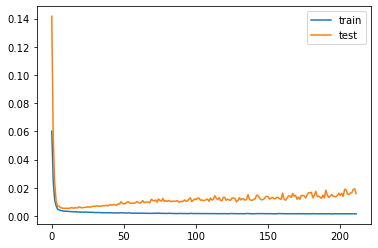

In [17]:
from matplotlib import pyplot
# evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
predictions = model.predict(X_test)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

ValueError: operands could not be broadcast together with shapes (474,5,1) (474,1) 

In [19]:
# train set의 평균을 예측값으로 했을 때의 오차
mu = y_train.mean()
np.sqrt(np.mean((y_test - mu) ** 2)) 

0.5691948926795429

In [ ]:
# 그래프로 확인
train = df_scaled[:train_date][['Labeling']]
valid = df_scaled[train_date:][['Labeling']]
valid['Predictions'] = sc2.inverse_transform(predictions)

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('prediction', fontsize=18)
#plt.plot(train)
plt.plot(valid['Labeling'])
plt.plot(valid['Predictions'])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import datetime
date_1 = pd.to_datetime(train_date)
view_date = date_1 + datetime.timedelta(days=30)
view_date = str(view_date)
view_date = view_date[:10]
view_date

In [ ]:
# 일부분 확대
valid = df_scaled[train_date:][['Labeling']]
valid['Predictions'] = sc2.inverse_transform(predictions)

valid = valid[train_date:view_date]

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('prediction', fontsize=18)
#plt.plot(train)
plt.plot(valid['Labeling'])
plt.plot(valid['Predictions'])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# XGBoost
def xgBoostGridSearch(trainTuple, validTuple, paramDic, colNmList, obj='reg:squarederror') :
    parameters = {
        'booster' :['gbtree'],
        'learning_rate':paramDic['learning_rate'],
        'n_estimators':paramDic['n_estimators'],
        'max_depth':paramDic['max_depth'],
        'gamma':paramDic['gamma'],
        'random_state':paramDic['random_state'],
        #'early_stoppings':paramDic['early_stoppings']
    }
    cv=TimeSeriesSplit(n_splits=5)
    #eval_set = [trainTuple, validTuple]
    # objective : 목적함수. 이 함수를 통해 나온 값이 최소화되는 방향으로 학습된다.
    # binary:logistic : 이항 분류(binary class)에 사용
    # multi:softmax / multi:softprob : 다항 분류(multi class)에 사용.
    if obj == 'binary:logistic' :
        model = xgb.XGBClassifier(objective=obj)
    else :
        model = xgb.XGBRegressor(objective=obj)
    
    clf = GridSearchCV(model, parameters, cv=cv)
    
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    clf.fit(dtrain, trainTuple[1])
    print(f'Best params : {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')
    return clf

def xgBoost(clf, trainTuple, validTuple, colNmList, obj='reg:squarederror', fiGraph=True) :
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    dvalid = pd.DataFrame(validTuple[0], columns=colNmList)
    #eval_set = [(dtrain, trainTuple[1]), (dvalid, validTuple[1])]
    eval_set = [(dvalid, validTuple[1])]
    
    if obj == 'binary:logistic' :
        model = xgb.XGBClassifier(**clf.best_params_, objective=obj)
    else :
        model = xgb.XGBRegressor(**clf.best_params_, objective=obj)
    
    model.fit(dtrain, trainTuple[1], eval_set=eval_set, verbose=False)
    model.get_booster().get_score(importance_type='weight')
    
    if fiGraph :
        plot_importance(model)
        
    return model

def pred(model, testTuple, df_scaled, colNmList, scaler, colNm='Labeling') :
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    dtest = pd.DataFrame(testTuple[0], columns=colNmList)
    y_pred = model.predict(dtest)
    print(f'mean_squared_error = {mean_squared_error(testTuple[1], y_pred)}')

    # 예측값과 실제값 그려보기
    # 그래프로 확인
    train = df_scaled[:train_date][['Labeling']]
    valid = df_scaled[train_date:][['Labeling']]
    valid['Predictions'] = scaler.inverse_transform(np.reshape(y_pred, (y_pred.shape[0], 1)))

    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('prediction', fontsize=18)
    #plt.plot(train)
    plt.plot(valid['Labeling'])
    plt.plot(valid['Predictions'])
    plt.legend(['Val', 'Predictions'], loc='lower right')
    plt.show()

In [ ]:
colList = list(df_scaled.columns)
colList.remove('Labeling')
colList

In [ ]:
import xgboost as xgb

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

X_train_ = []
y_train_ = []
for i in range(0, train_set.shape[0]):
    X_train_.append(train_set[i, 0:train_set.shape[1]-1])
    y_train_.append(train_set[i, train_set.shape[1]-1:])
X_train_, y_train_ = np.array(X_train_), np.array(y_train_)

sc1_ = MinMaxScaler()
sc2_ = MinMaxScaler()
X_train_ = sc1_.fit_transform(X_train_)  
y_train_ = sc2_.fit_transform(y_train_)

X_test_ = []
y_test_ = []
for i in range(train_set.shape[0], df_scaled.shape[0]):
    X_test_.append(df_scaled.values[i, 0:train_set.shape[1]-1])
    y_test_.append(df_scaled.values[i, train_set.shape[1]-1:])
X_test_, y_test_ = np.array(X_test_), np.array(y_test_)

X_test_ = sc1_.transform(X_test_)  
y_test_ = sc2_.transform(y_test_)

trainTuple = (X_train_, y_train_)
testTuple = (X_test_, y_test_)
validTuple = testTuple

paramDic = {}
paramDic['n_estimators'] = [100, 200]
paramDic['max_depth'] = [5, 8]
paramDic['gamma'] = [0]
paramDic['random_state'] = [50]
paramDic['learning_rate'] = [0.05, 0.1]

clf = xgBoostGridSearch(trainTuple, validTuple, paramDic, colList)
model = xgBoost(clf, trainTuple, validTuple, colList)

pred(model, testTuple, df_scaled, colList, sc2_)